<div align="center">

  
  <a href="https://github.com/1treu1/DNI-Extract" target="_blank">
    <img width="1024", src="https://nanonets.com/blog/content/images/2020/09/landing-ocr-1.gif" width="500" height="500"></a>


<br>
  <a href="https://colab.research.google.com/drive/1-oePAAYQhTHpLUhq2o_M4sE7LxvbaoLs?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  <a href="https://github.com/1treu1/DNI-Extract"><img src="https://img.shields.io/badge/github-Open In Github-brightgreen.svg" alt="Open In Github"></a>
</br>


En este proyecto vamos a extraer la informacion relevante de los DNI. Para esto haremos lo siguiente:

</div>


*   Detección de objetos con Yolov8
*   Haremos OCR en los Bouding Boxes.




# Requerimientos

In [ ]:
%pip install ultralytics
!pip install easyocr
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing

In [ ]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.3/78.2 GB disk)


# 6. DATA



*   Los datos de entrenamiento se tomaron de RoboFlow: https://universe.roboflow.com/





In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from roboflow import Roboflow
# Descargando los datos
rf = Roboflow(api_key="VV8kK8EBE6GqIwE6zH5L")
project = rf.workspace("bms-ur6hn").project("passport-sscsb")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.202, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to passport-1 in yolov8:: 100%|██████████| 694/694 [00:00<00:00, 5753.44it/s]


* Modificando un poco el archivo data.yaml para pasarle correctamente las rutas de las imagenes

In [ ]:
import yaml

data = {}
with open("/content/passport-1/data.yaml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
        data['test'] = '/content/passport-1/test/images'
        data['train'] = '/content/passport-1/train/images'
        data['val'] = '/content/passport-1/valid/images'
    except yaml.YAMLError as exc:
        data = exc

# Guardando el archivo YAML en la carpeta `/content/passport-1/`
with open("/content/passport-1/data.yaml", "w") as stream:
    yaml.dump(data, stream)


## 1. Detección de Objetos

Entrenando un modelo de Detección de Objetos con YoloV8


In [ ]:
model = YOLO('yolov8n.pt')  # Cargando modelo preentrenado
model.train(data='/content/passport-1/data.yaml', epochs=100)  # Entrenando el modelo
eval = model.val() #Evaluando el modelo

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/passport-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False,

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import easyocr
detect = model.predict(r'/content/passport-1/test/images/12_jpg.rf.3d91c6d93f1cf854fa69b9f8be2b164f.jpg')

# extrayendo los datos del diccionario
for result in detect:
    boxes = result.boxes.data  # Bounding Boxes
    img2 = result.orig_img
    labels = result.names
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs1 = result.probs  # Class probabilities for classification outputs



image 1/1 /content/passport-1/test/images/12_jpg.rf.3d91c6d93f1cf854fa69b9f8be2b164f.jpg: 640x640 1 Authority, 1 Code, 1 Date of Birth, 1 Date of expiration, 1 Date of issue, 1 Gender, 1 Given Names, 1 Nationality, 1 Passport No-, 1 Place of birth, 1 Surname, 1 Type, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


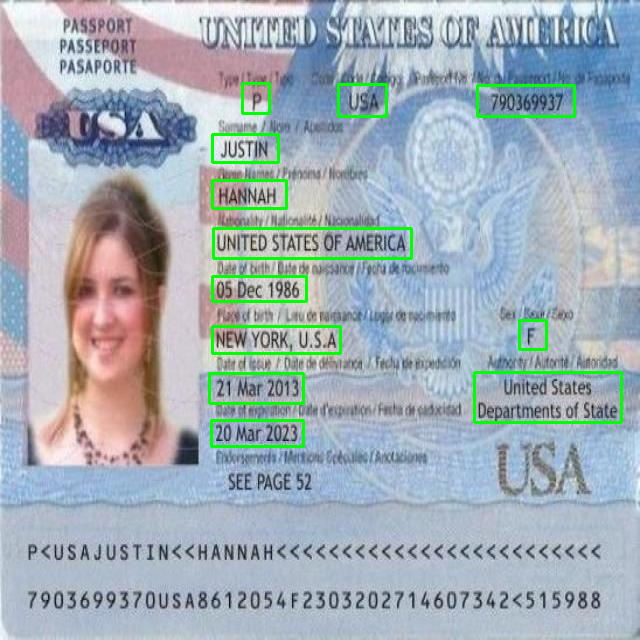

In [ ]:
# Extrayendo Bounding Boxes
img_color = img2.copy()
boxes = boxes.detach().cpu().numpy()
prob = boxes[:,len(boxes[0])-2]
id = boxes[:,len(boxes[0])-1]
boxes = boxes[:,:4].astype(int)
# Creando Bounding Boxes en la imagen con OpenCV
for box in boxes:
  pt0 = np.array((box[0],box[1]))
  pt1 = np.array((box[2],box[3]))
  #print(pt1[0])
  #cv2.rectangle(img_color, pt0, (pt1[0], pt1[1] - 23), (204, 72, 63), -1)
  #cv2.putText(img_color, 'a', (pt0[0], pt0[1] -3), 2, 0.8, (255, 255, 255), 1)
  cv2.rectangle(img_color, pt0, pt1, (0, 255, 0), 2) # Creando Rectangulo
cv2_imshow(img_color) #Mostrando la deteccion

OCR sobre la información detectada


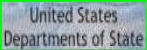

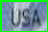

xc


xc


xc


In [ ]:
#OCR
reader = easyocr.Reader(["en"], gpu=True)
result = []
dic = {}
print("OCR sobre la información detectada")
for box, i in zip(boxes, id):
  #Tomando las cordenadas de los bounding Boxes
  pt0 = np.array((box[0],box[1]))
  pt1 = np.array((box[2],box[3]))
  #Extrayendo solamente el Bounding Box de la imagen
  img = img_color.copy()
  out = img[box[1]:box[3],box[0]:box[2]] #
  try:
    cv2_imshow(out)
    result = reader.readtext(out, paragraph=True, batch_size=16, workers=8) #Convirtiendo la imagen en Texto
    #print(result[0][1])
    dic[i] = result[0][1]
    #print(dic[str(i)])
  except:
     print("xc")
  #cv2_imshow(img)
#cv2_imshow(out)

In [ ]:
#Prediction
print(dic)

{3.0: '20 Mar 2023', 9.0: 'NEW YORK, US.A', 0.0: 'United States Departmerits of State', 10.0: 'Justin', 4.0: '121 Mar 2013', 6.0: 'HANNAH', 2.0: '05 Dec 1986', 8.0: '790369937', 7.0: '(unIteD STATES OF AMERICA'}


In [ ]:
labels

{0: 'Authority',
 1: 'Code',
 2: 'Date of Birth',
 3: 'Date of expiration',
 4: 'Date of issue',
 5: 'Gender',
 6: 'Given Names',
 7: 'Nationality',
 8: 'Passport No-',
 9: 'Place of birth',
 10: 'Surname',
 11: 'Type',
 12: 'words'}